# Quantum Machine Learning for Image Classification

 The starting point is a convolutional neural network—ResNet18, introduced by Microsoft in 2016 [3]—which is pre-trained on the public ImageNet dataset. We replace the last fully connected layer with a *dressed quantum circuit* [1] that we train on a different dataset.

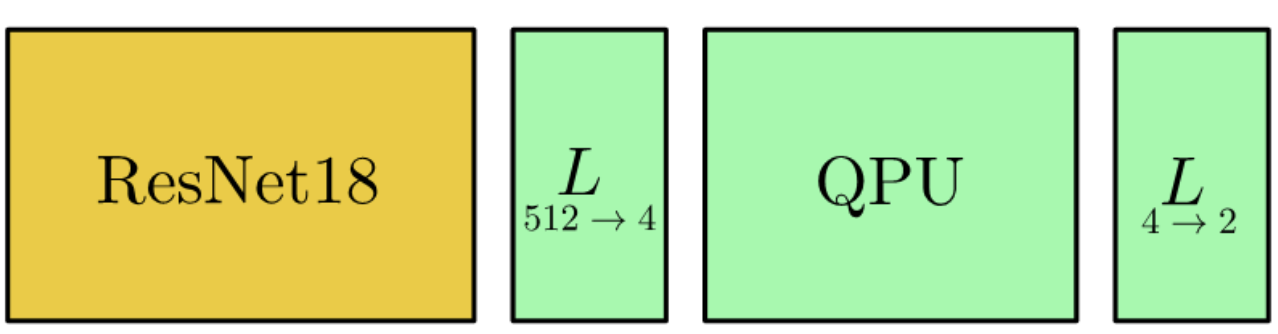

## Overview of the Approach
The starting point is a convolutional neural network—ResNet18, introduced by Microsoft in 2016—which is pre-trained on the public ImageNet dataset. We replace the last fully connected layer with a *dressed quantum circuit* that we train on a different dataset. This section outlines the hybrid architecture employed for image classification, detailing the integration of a pre-trained ResNet18 model with a quantum circuit to create a powerful classifier. The quantum component aims to exploit quantum computation's potential for certain tasks.

In [1]:
# OpenMP: number of parallel threads.
%env OMP_NUM_THREADS=1

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

# Pennylane
import pennylane as qml
from pennylane import numpy as np

# Other tools
import time
import copy

env: OMP_NUM_THREADS=1


## Defining the Model Parameters and Quantum Device
Here, we define the key parameters for our hybrid quantum-classical model, including the selection of image classes (cats and dogs), the configuration of the quantum circuit (number of qubits, depth, learning rate, etc.), and the initialization of the quantum device for simulation. This setup is crucial for tailoring the model's learning process and computational characteristics.

In [2]:
filtered_classes = ['cat', 'dog']  
n_qubits = 4                      
quantum = True                 
                                 
classical_model = '512_n'         
step = 0.001                     
batch_size = 8                   
num_epochs = 3          
q_depth = 5                      
gamma_lr_scheduler = 1                                
max_layers = 15              
q_delta = 0.01                   
rng_seed = 0                     
start_time = time.time()         

## Initializing the Quantum Device
This cell initializes the quantum device with the specified number of qubits. The quantum device will be used to run the quantum circuits that form part of the hybrid model. PennyLane's `default.qubit` plugin is used for simulating quantum operations on the classical hardware.

In [3]:
dev = qml.device('default.qubit', wires=n_qubits)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Dataset loading

In [5]:
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(224),     
        #transforms.RandomHorizontalFlip(),    
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


trainset_full = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=data_transforms['train'])
testset_full = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=data_transforms['val'])
image_datasets_full={'train': trainset_full, 'val': testset_full}

class_names = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

filtered_labels=[class_names.index(cl) for cl in filtered_classes]
sub_indices={'train': [], 'val': []}
for phase in ['train', 'val']:
    for idx, label in enumerate(image_datasets_full[phase].targets):  
        if label in filtered_labels:
            sub_indices[phase].append(idx)
            
image_datasets = {x: torch.utils.data.Subset(image_datasets_full[x], sub_indices[x])
                for x in ['train', 'val']}

def labels_to_filtered(labels):
    """Maps CIFAR labels (0,1,2,3,4,5,6,7,8,9) to the index of filtered_labels"""
    return [filtered_labels.index(label) for label in labels]

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                  batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']}

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

Files already downloaded and verified
Files already downloaded and verified


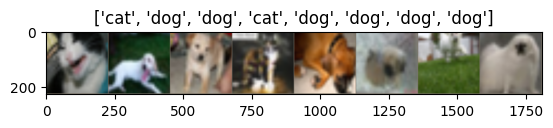

In [6]:
inputs, classes = next(iter(dataloaders['val']))

out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [7]:
torch.manual_seed(rng_seed)
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                  batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']}

## Hybrid transfer learning model (classical-to-quantum).


In [8]:
def H_layer(nqubits):
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)
        
def RY_layer(w):Give 
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)

def entangling_layer(nqubits):

    for i in range(0, nqubits - 1, 2):
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1,2): 
        qml.CNOT(wires=[i, i + 1])

In [9]:
@qml.qnode(dev, interface='torch')
def q_net(q_in, q_weights_flat):
        
    q_weights = q_weights_flat.reshape(max_layers, n_qubits)
        
    H_layer(n_qubits)
        
    RY_layer(q_in)
       
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k+1])

    return [qml.expval(qml.PauliZ(j)) for j in range(n_qubits)]


In [10]:
class Quantumnet(nn.Module):
        def __init__(self):
            super().__init__()
            self.pre_net = nn.Linear(512, n_qubits)
            self.q_params = nn.Parameter(q_delta * torch.randn(max_layers * n_qubits))
            self.post_net = nn.Linear(n_qubits, len(filtered_classes))

        def forward(self, input_features):
            pre_out = self.pre_net(input_features) 
            q_in = torch.tanh(pre_out) * np.pi / 2.0   
            
            q_out = torch.Tensor(0, n_qubits)
            q_out = q_out.to(device)
            for elem in q_in:
                q_out_elem = torch.tensor(q_net(elem, self.q_params), dtype=torch.float, device=device).unsqueeze(0)
                q_out = torch.cat((q_out, q_out_elem))
            return self.post_net(q_out)

In [11]:
model_hybrid = torchvision.models.resnet18(pretrained=True)

for param in model_hybrid.parameters():
    param.requires_grad = False

if quantum:
    model_hybrid.fc = Quantumnet()

elif classical_model == '512_n':
    model_hybrid.fc = nn.Linear(512,len(filtered_classes))

elif classical_model == '512_nq_n':
    model_hybrid.fc = nn.Sequential(nn.Linear(512, n_qubits),torch.nn.ReLU(),nn.Linear(n_qubits, len(filtered_classes))) 

elif classical_model == '551_512_n':
    model_hybrid.fc = nn.Sequential(nn.Linear(512, 512), torch.nn.ReLU(), nn.Linear(512, len(filtered_classes)))

model_hybrid = model_hybrid.to(device)

/Users/manavkumardubey/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/manavkumardubey/Library/Python/3.9/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Training and results


In [12]:
criterion = nn.CrossEntropyLoss()

In [13]:
optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)

In [14]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_hybrid, step_size=3, gamma=gamma_lr_scheduler)

In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 10000.0
    best_acc_train = 0.0
    best_loss_train = 10000.0
    print('Training started:')
    for epoch in range(num_epochs):
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train() 
            else:
                model.eval()   
            running_loss = 0.0
            running_corrects = 0
            n_batches = dataset_sizes[phase] // batch_size
            it = 0
            for inputs, cifar_labels in dataloaders[phase]:
                since_batch = time.time()
                batch_size_ = len(inputs)
                inputs = inputs.to(device)
                labels = torch.tensor(labels_to_filtered(cifar_labels))
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * batch_size_
                batch_corrects = torch.sum(preds == labels.data).item()
                running_corrects += batch_corrects
                print('Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}'.format(phase, epoch + 1, num_epochs, it + 1, n_batches + 1, time.time() - since_batch), end='\r', flush=True)
                it += 1
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            print('Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}             '.format('train' if phase == 'train' else 'val  ', epoch + 1, num_epochs, epoch_loss, epoch_acc))
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
            if phase == 'train' and epoch_acc > best_acc_train:
                best_acc_train = epoch_acc
            if phase == 'train' and epoch_loss < best_loss_train:
                best_loss_train = epoch_loss
    model.load_state_dict(best_model_wts)
    time_elapsed = time.time() - since
    print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best test loss: {:.4f} | Best test accuracy: {:.4f}'.format(best_loss, best_acc))
    return model


Training the model-

In [16]:
model_hybrid = train_model(model_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs=num_epochs)

Training started:


/Users/manavkumardubey/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Phase: train Epoch: 1/3 Loss: 0.6964 Acc: 0.5117             
Phase: val   Epoch: 1/3 Loss: 0.6889 Acc: 0.5360             
Phase: train Epoch: 2/3 Loss: 0.6876 Acc: 0.5385             
Phase: val   Epoch: 2/3 Loss: 0.6890 Acc: 0.5295             
Phase: train Epoch: 3/3 Loss: 0.6862 Acc: 0.5504             
Phase: val   Epoch: 3/3 Loss: 0.6885 Acc: 0.5380             
Training completed in 30m 30s
Best test loss: 0.6885 | Best test accuracy: 0.5380


In [17]:
if quantum:
        torch.save(model_hybrid.state_dict(), 
            'quantum_' + filtered_classes[0] + '_' + filtered_classes[1] + '.pt'
        )
else:
        torch.save(model_hybrid.state_dict(), 
            'classical_' + filtered_classes[0] + '_' + filtered_classes[1] + '.pt'
        )
print("Model state_dict saved.")

Model state_dict saved.


In [18]:
if quantum:
    model_hybrid.load_state_dict(torch.load(
        'quantum_' + filtered_classes[0] + '_' + filtered_classes[1] + '.pt'
        )
    )
                                 
else:
    model_hybrid.load_state_dict(torch.load(
        'classical_' + filtered_classes[0] + '_' + filtered_classes[1] + '.pt'
        )
    )

In [23]:
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix
criterion = nn.CrossEntropyLoss()
running_loss = 0.0
running_corrects = 0
n_batches = dataset_sizes['val'] // batch_size
it = 0

# Initialize lists to collect true labels and predictions
all_preds = []
all_labels = []

model_hybrid.eval()

for inputs, cifar_labels in dataloaders['val']:
    inputs = inputs.to(device)
    labels = torch.tensor(labels_to_filtered(cifar_labels))
    labels = labels.to(device)
    batch_size_ = len(inputs)
    with torch.set_grad_enabled(False):
        outputs = model_hybrid(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
    running_loss += loss.item() * batch_size_
    batch_corrects = torch.sum(preds == labels.data).item()
    running_corrects += batch_corrects
    # Append batch predictions and labels to the lists
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())
    print('Iter: {}/{}'.format(it+1, n_batches+1), end='\r', flush=True)
    it += 1
                    
# Now compute F1 score and confusion matrix
f1 = f1_score(all_labels, all_preds, average='macro')
conf_matrix = confusion_matrix(all_labels, all_preds)

print('\nTest Loss: {:.4f} Test Acc: {:.4f}'.format(epoch_loss, epoch_acc))
print(f'F1 Score: {f1}')
print('Confusion Matrix:')
print(conf_matrix)

Iter: 250/251
Test Loss: 0.6885 Test Acc: 0.5380
F1 Score: 0.5378331577699549
Confusion Matrix:
[[519 481]
 [443 557]]


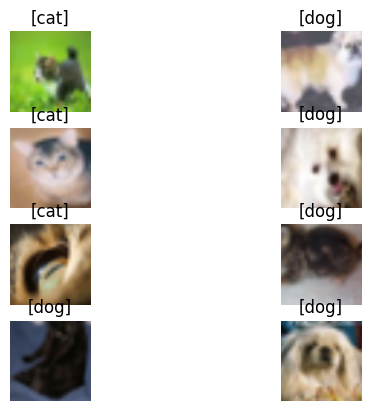

In [20]:
def visualize_model(model, num_images=6, fig_name='Predictions'):
    images_so_far = 0
    fig = plt.figure(fig_name)
    model.eval()
    with torch.no_grad():
        for i, (inputs, cifar_labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = torch.tensor(labels_to_filtered(cifar_labels))
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('[{}]'.format(filtered_classes[preds[j]]))
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    return
        
visualize_model(model_hybrid, num_images=batch_size)
